In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook

import sklearn
import matplotlib as mpl
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

In [3]:
# Dataset

# use this if in fmi-hw... repo
# train = pd.read_csv("data/spooky/train.zip", index_col=['id'])
# test = pd.read_csv("data/spooky/test.zip", index_col=['id'])
# sample_submission = pd.read_csv("data/spooky/sample_submission.zip", index_col=['id'])

train = pd.read_csv("data/train.zip", index_col=['id'])
test = pd.read_csv("data/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/sample_submission.zip", index_col=['id'])


print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [4]:
train.head(5)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


# Идеи за фичъри:
    
* CountVectorizer, Tfidf
* Preprocessing - stop words, lematization
* Други фичъри - бр. думи , бр. стоп думи, бр. пунктуация, бр. ГЛАВНИ букви и т.н.
* Намиране на общи теми чрез LDA
* Word Embeddings с невронни мрежи


# Първо - baseline модел

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [6]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3)

array([ 0.78783701,  0.79635305,  0.79509579])

In [7]:
from sklearn.model_selection import cross_val_predict
prediction = cross_val_predict(pipeline, train.text, train.author, cv=3, n_jobs=3)

In [8]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.793094642219


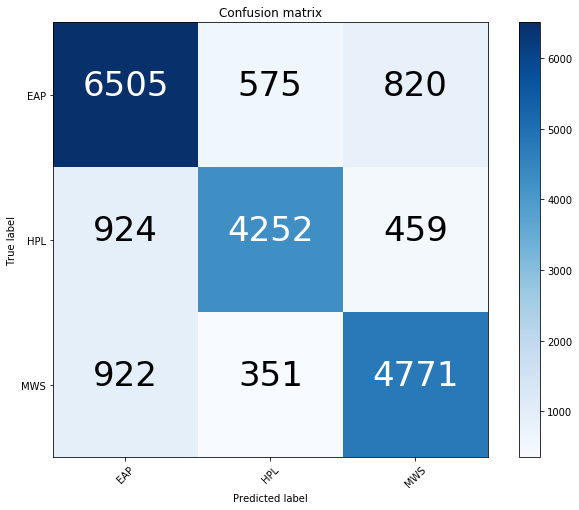

In [9]:
pipeline.fit(train.text, train.author)
authors = pipeline.classes_
print(accuracy_score(train.author, prediction))
plot_confusion_matrix(train.author, prediction, classes=authors)

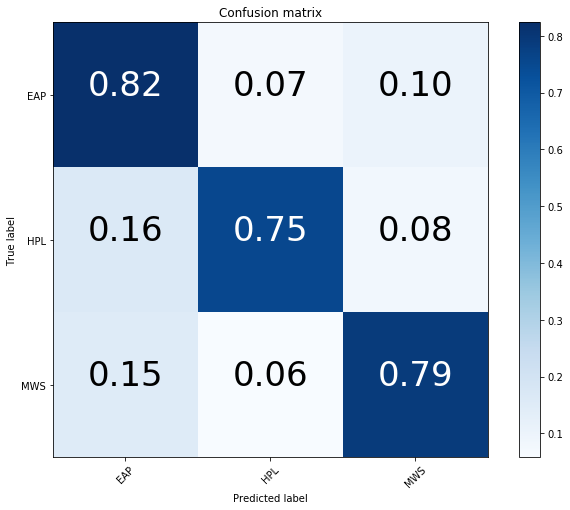

In [10]:
plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)

Да пробваме с RF

In [11]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.62300858  0.61798958  0.60551724]

[-1.36418837 -1.38716468 -1.43783028]

In [12]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
#                       scoring='neg_log_loss'))

# Получихме малко по-добри резултати

[ 0.81449142  0.81673307  0.81348659]

[-0.47678328 -0.47558895 -0.47131481]

Следващото е за да имаме "explore" датасет

In [13]:
explore = train.copy()

In [14]:
# # бр. думи в текста
# explore['words'] = explore.text.apply(lambda s: len(str(s).split()))

# # бр. уникални думи
# explore['unique_words'] = explore.text.apply(lambda s: len(set(str(s).split())))

# # бр. символи
# explore['symbols'] = explore.text.str.len()

# # бр. уникални символи
# explore['unique_symbols'] = explore.text.apply(lambda s: len(set(str(s))))

# import string

# # бр. главни букви
# explore['capital_letters'] = explore.text.apply(lambda s: sum([str.isupper(c) for c in str(s)]))

# # бр. на думи съдържащи само главни буква
# explore['only_capital_letter_words'] = explore.text.apply(lambda s: sum([str.isupper(w) for w in str(s).split()]))

# # средна дължина на дума
# explore['average_word_lenght'] = explore.text.apply(lambda s: np.mean([len(w) for w in str(s).split()]))

# # бр. цифрите
# explore['digits'] = explore.text.apply(lambda s: sum([str.isdigit(c) for c in str(s)]))

# # бр. на препинателни знаци
# explore["punctuation"] = train.text.apply(lambda s: sum([c in string.punctuation for c in str(s)]) )

In [17]:
import nltk
# nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [18]:
# features_names = list(set(explore.columns) - {'text', 'author'})
# print('numeric features', features_names)

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stem = PorterStemmer()

explore['stemmed'] = explore.text.apply(lambda t: " ".join([stem.stem(w) for w in t.split()])) 

explore[['stemmed', 'text']].head()

,stemmed,text
id,,
id26305,"thi process, however, afford me no mean of asc...","This process, however, afforded me no means of..."
id17569,It never onc occur to me that the fumbl might ...,It never once occurred to me that the fumbling...
id11008,"In hi left hand wa a gold snuff box, from whic...","In his left hand was a gold snuff box, from wh..."
id27763,how love is spring As we look from windsor ter...,How lovely is spring As we looked from Windsor...
id12958,"find noth else, not even gold, the superintend...","Finding nothing else, not even gold, the Super..."


In [20]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, explore.stemmed, train.author, cv=3, n_jobs=3)

# Резултати от същия pipeline използвайки колона text:
# array([ 0.78783701,  0.79635305,  0.79509579])

array([ 0.78477328,  0.78562672,  0.78482759])

# Допълнителните фичъри не сработиха, стеминга също. 

Остават да пробвам:

* Оптимизиране на модела с CountVectorizer.
* Добавяне на още фичъри, от латентни пространства (LDA) - topic modeling.
* Word embeddings с невронни мрежи.
* Стакинг на класификатори.

За сега ще разгледаме само оптимизирането на модела.

Първо да опишем параметрите за търсене в трансфомацията (CountVectorizer)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

params_count_char = {"features__ngram_range": [(1,4), (1,5), (1,6)],
                      "features__analyzer": ['char'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

In [22]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
def random_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search()

== original ==

Model with rank: 1
Mean validation score: -0.475 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 2
Mean validation score: -0.482 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 3
Mean validation score: -0.486 (std: 0.001)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 3}

Model with rank: 4
Mean validation score: -0.508 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}

Model with rank: 5
Mean validation score: -0.525 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}


== local results ==

Model with rank: 1
Mean validation score: -0.474 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 2
Mean validation score: -0.513 (std: 0.002)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 3}

Model with rank: 3
Mean validation score: -0.515 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}

Model with rank: 4
Mean validation score: -0.547 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 1), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.3}

Model with rank: 5
Mean validation score: -0.547 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 0.9, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.3}

# Tfidf = Term-frequency inverse document-frequency

* Идеята е да сложи тежести и значимост на всички думи или n-grams.
* Напр. "новина" е доста често срещана дума и може да бъде в различни контексти. 
* За разлика от "електроенцефалограф", която е много по-рядко срещана и директно дава медицински контекст.


* TF брои колко пъти се среща думата в текущия текст (пасаж, изречение, документ, семпъл).
* IDF брои колко пъти тази дума се среща изцяло в корпуса с които тренираме.

In [24]:
tfidf = TfidfVectorizer()

In [25]:
def random_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search() # предишния най-добър резултат:  -0.475 

== original ==

Model with rank: 1
Mean validation score: -0.469 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 1.0, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 2
Mean validation score: -0.471 (std: 0.006)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 3, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 3
Mean validation score: -0.483 (std: 0.008)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 4
Mean validation score: -0.495 (std: 0.002)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.6, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 5
Mean validation score: -0.522 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 10, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}


== local result ==

Model with rank: 1
Mean validation score: -0.468 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 2
Mean validation score: -0.484 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 3
Mean validation score: -0.484 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 4
Mean validation score: -0.488 (std: 0.008)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 5, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 5
Mean validation score: -0.495 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Има леко подобрение в `LogLoss`.

Да пробваме да сменим и класификатора с друг класически за класификация на текст: `Naive Bayes`

In [26]:
from sklearn.naive_bayes import MultinomialNB

def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search()  # Предишния най-добър резултат: -0.469

== original ==

Model with rank: 1
Mean validation score: -0.423 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 2
Mean validation score: -0.465 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 3, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 3
Mean validation score: -0.469 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 4
Mean validation score: -0.495 (std: 0.002)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 5
Mean validation score: -0.496 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.6, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}


== local ==

Model with rank: 1
Mean validation score: -0.422 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 2
Mean validation score: -0.496 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 3
Mean validation score: -0.502 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 3
Mean validation score: -0.502 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 5
Mean validation score: -0.524 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 10, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Тук има още подобрение в метриката.

Искам да го пробвам и със stemming.

Освен това се вижда, че избира най-ниската предоставена стойност за `alpha`, може би трябва да пробвам с още по-ниски.

In [27]:
def random_search():
    params = {
        "clf__alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.3]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(explore.stemmed, train.author)
    report(random_search.cv_results_)
    
# random_search()  # -0.423

Model with rank: 1
Mean validation score: -0.438 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.6, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 2
Mean validation score: -0.443 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 0.6, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.05}

Model with rank: 3
Mean validation score: -0.453 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 4
Mean validation score: -0.471 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 5
Mean validation score: -0.472 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.5, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.05}


In [28]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Lambda, Concatenate
from keras.optimizers import RMSprop, Adam
from keras import regularizers, objectives, metrics
from keras.models import Model
from keras import backend as K

from IPython.display import display

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [29]:
from gensim import corpora

documents = train.text

In [30]:
# remove common words and tokenize
# stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stopwords] #was stoplist
         for document in documents]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

from pprint import pprint  # pretty-printer
pprint(texts[:2])

[['process,',
  'however,',
  'afforded',
  'means',
  'ascertaining',
  'dimensions',
  'might',
  'make',
  'return',
  'point',
  'whence',
  'set',
  'out,',
  'without',
  'aware',
  'perfectly',
  'uniform',
  'seemed',
  'wall.'],
 ['never', 'occurred', 'fumbling', 'might', 'mere', 'mistake.'],
 ['left',
  'hand',
  'gold',
  'snuff',
  'box,',
  'which,',
  'hill,',
  'cutting',
  'manner',
  'fantastic',
  'steps,',
  'took',
  'snuff',
  'incessantly',
  'air',
  'greatest',
  'possible',
  'self',
  'satisfaction.'],
 ['lovely',
  'spring',
  'looked',
  'windsor',
  'terrace',
  'sixteen',
  'fertile',
  'counties',
  'spread',
  'beneath,',
  'speckled',
  'happy',
  'cottages',
  'wealthier',
  'towns,',
  'looked',
  'former',
  'years,',
  'heart',
  'cheering',
  'fair.'],
 ['finding',
  'nothing',
  'else,',
  'even',
  'gold,',
  'superintendent',
  'abandoned',
  'perplexed',
  'look',
  'occasionally',
  'steals',
  'countenance',
  'sits',
  'thinking',
  'desk.']

In [31]:
import pickle

FILENAME = "processed_texts.pickle"

# create pickle
# pickle.dump(texts, open(FILENAME, "wb" ))

# depicke
texts = pickle.load(open(FILENAME, "rb"))

In [32]:
dictionary = corpora.Dictionary(texts)
dictionary.save('spooky.dict')  # store the dictionary, for future reference
print(len(dictionary))

22328


In [33]:
# corpus = [dictionary.doc2bow(text) for text in texts]
# corpora.MmCorpus.serialize('spooky.mm', corpus)  # store to disk, for later use

#restore from disk
corpus = corpora.mmcorpus.MmCorpus('spooky.mm')

## similarities.docsim.Similarity

In [35]:
from gensim import similarities

In [36]:
# index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)
index = similarities.docsim.Similarity('/home/bob/tmp', corpus, num_features=len(dictionary)) 

In [69]:
corpus[156]

[(545, 1.0), (1137, 1.0), (1598, 1.0), (1599, 1.0), (1600, 1.0), (1601, 1.0)]

In [38]:
# sims = index[tfidf[corpus[0]]]
sims = index[corpus[0]]

In [39]:
results = list(enumerate(sims))

In [40]:
results[:5]

[(0, 0.99999982), (1, 0.093658581), (2, 0.0), (3, 0.0), (4, 0.0)]

In [65]:
from operator import itemgetter
    
top = sorted(results, key=itemgetter(1), reverse=True)
top[:5]

[(0, 0.99999982),
 (14771, 0.260133),
 (8578, 0.22941573),
 (12208, 0.22941573),
 (12524, 0.22941573)]

In [44]:
type(index)

gensim.similarities.docsim.Similarity

In [56]:
print('in df:     ', train.text[0],'\n')
print('as doc:    ', documents[0],'\n')
print('as tokens: ', texts[0],'\n')
print('as vec:    ', corpus[0],'\n')

in df:      This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. 

as doc:     This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. 

as tokens:  ['process,', 'however,', 'afforded', 'means', 'ascertaining', 'dimensions', 'might', 'make', 'return', 'point', 'whence', 'set', 'out,', 'without', 'aware', 'perfectly', 'uniform', 'seemed', 'wall.'] 

as vec:     [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0)] 



In [61]:
print('unsorted sims to vec[0]', sims[:10])

unsorted sims to vec[0] [ 0.99999982  0.09365858  0.          0.          0.          0.          0.
  0.          0.03673591  0.        ]


In [66]:
print(documents[0])
for sim in top[:10]:
    print(sim[1], train.author[sim[0]], documents[sim[0]],'\n')

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
1.0 EAP This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. 

0.260133 EAP The expression of his smile, however, was by no means unpleasing, as might be supposed; but it had no variation whatever. 

0.229416 EAP Much, however, might be ascertained. 

0.229416 EAP I reapproached the wall. 

0.229416 HPL They seemed to hate and fear him at the same time, and he seemed to return these sentiments. 

0.229416 EAP There was nothing in this, however, to make him sob. 

0.216295 EAP At first he stared at me as if he found it impossible to comprehend the witticism of my remark; but as its p

Чисто технически може да се направи някакво осредняване на резултати - например резултатите от сравнение към documents[0] и сравнение към documents[2] - като и двата записа са "EAP". Но не ми се вижда правилно.

Не мисля, че посоката е подходяща за нашия случай, защото сравненията са директни, вместо да се извлича "пространство" което да генерализира стила/автора. По-добре да проверим какво друго има в gensim.

In [74]:
from gensim import sklearn_api

from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('features', sklearn_api.text2bow.Text2BowTransformer()),
    ('clf', RandomForestClassifier())
])

try:
    print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
    print(cross_val_score(pipeline, train.text, train.author, 
                    cv=3, n_jobs=3, scoring='neg_log_loss'))
except ValueError as e:
#     print(e)
    pass

JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <modul

ValueError: setting an array element with a sequence.

In [79]:
something = sklearn_api.text2bow.Text2BowTransformer()
print(type(something))
other = something.fit_transform(train.text)
print(type(other))
print(train.text[0], other[0], '\n', train.text[656], other[656])

<class 'gensim.sklearn_api.text2bow.Text2BowTransformer'>
<class 'list'>
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. [(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 4), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)] 
 Dropping of its own accord upon his exit or perhaps purposely closed, it had become fastened by the spring; and it was the retention of this spring which had been mistaken by the police for that of the nail, farther inquiry being thus considered unnecessary. [(3, 1), (7, 1), (13, 1), (20, 3), (29, 4), (44, 1), (60, 1), (70, 1), (71, 1), (78, 2), (95, 2), (133, 1), (143, 2), (174, 1), 

How is this supposed to work?!?

`tfidf.fit_transform(corpus)` returns matrix, while the `sklearn_api.text2bow.Text2BowTransformer().fit_transform(corpus)` returns some "BOW" format

OK - this might work

In [ ]:
pipeline = Pipeline([
    ('features', sklearn_api.text2bow.Text2BowTransformer()),
    ('lda', sklearn_api.ldamodel.LdaTransformer()),
    ('clf', RandomForestClassifier())
])

# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.48360907  0.48850751  0.48613027]<br>
[-2.1033608  -2.09791398 -2.30065565]

Преди да пообработим текста да видим Logistic Regression

In [81]:
pipeline = Pipeline([
    ('features', sklearn_api.text2bow.Text2BowTransformer()),
    ('lda', sklearn_api.ldamodel.LdaTransformer()),
    ('clf', LogisticRegression())
])


In [82]:
# %%time
# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))

/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[ 0.53722426  0.53463071  0.53563218]
CPU times: user 430 ms, sys: 169 ms, total: 599 ms
Wall time: 3min 41s


[ 0.53722426  0.53463071  0.53563218]<br>
CPU times: user 430 ms, sys: 169 ms, total: 599 ms<br>
Wall time: 3min 41s

In [83]:
# %%time
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[-0.96678405 -0.97080789 -0.97363342]
CPU times: user 453 ms, sys: 121 ms, total: 573 ms
Wall time: 3min 39s


[-0.96678405 -0.97080789 -0.97363342]<br>
CPU times: user 453 ms, sys: 121 ms, total: 573 ms<br>
Wall time: 3min 39s

Още един опит преди да окастрим текста

In [84]:
pipeline = Pipeline([
    ('features', sklearn_api.text2bow.Text2BowTransformer()),
    ('lda', sklearn_api.ldamodel.LdaTransformer(num_topics=21)),
    ('clf', LogisticRegression())
])

In [85]:
# %%time
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

[-0.98861154 -0.97565475 -0.99821168]
CPU times: user 381 ms, sys: 99.9 ms, total: 481 ms
Wall time: 2min 8s


[-0.98861154 -0.97565475 -0.99821168]<br>
CPU times: user 381 ms, sys: 99.9 ms, total: 481 ms<br>
Wall time: 2min 8s

In [86]:
explore.stemmed

id
id26305    thi process, however, afford me no mean of asc...
id17569    It never onc occur to me that the fumbl might ...
id11008    In hi left hand wa a gold snuff box, from whic...
id27763    how love is spring As we look from windsor ter...
id12958    find noth else, not even gold, the superintend...
                                 ...                        
id17718    I could have fancied, while I look at it, that...
id08973     the lid clench themselv togeth as if in a spasm.
id05267    mai il faut agir that is to say, a frenchman n...
id17513    for an item of news like this, it strike us it...
id00393    He laid a gnarl claw on my shoulder, and it se...
Name: stemmed, Length: 19579, dtype: object

In [101]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, remove_stopwords

# CUSTOM_FILTERS = [strip_punctuation, remove_stopwords]
# explore['stemmed2'] = [ preprocess_string(s, CUSTOM_FILTERS) for s in explore.stemmed]
# explore.stemmed2

explore['stemmed2'] = [ strip_punctuation(remove_stopwords(s.lower())) for s in explore.stemmed]
explore.stemmed2

id
id26305    thi process  however  afford mean ascertain di...
id17569                        onc occur fumbl mere mistake 
id11008    hi left hand wa gold snuff box  which  caper h...
id27763    love spring look windsor terrac sixteen fertil...
id12958    noth else  gold  superintend abandon hi attemp...
                                 ...                        
id17718    fancied  look it  emin landscap painter built ...
id08973                    lid clench themselv togeth spasm 
id05267      mai il faut agir say  frenchman faint outright 
id17513    item news like this  strike wa veri coolli rec...
id00393    laid gnarl claw shoulder  shake wa altogeth mi...
Name: stemmed2, Length: 19579, dtype: object

In [104]:
print(explore.loc['id17569'].stemmed, '|||', explore.loc['id17569'].stemmed2)

It never onc occur to me that the fumbl might be a mere mistake. ||| onc occur fumbl mere mistake 


Pipeline-a си е същия

In [105]:
# %%time
# print(cross_val_score(pipeline, explore.stemmed2, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

[-1.05550683 -1.02313271 -1.02899542]
CPU times: user 347 ms, sys: 92.8 ms, total: 440 ms
Wall time: 1min 27s


[-1.05550683 -1.02313271 -1.02899542]<br>
CPU times: user 347 ms, sys: 92.8 ms, total: 440 ms<br>
Wall time: 1min 27s

Поне е по-бързо. Да видим tfidf и повече фичъри.

In [108]:
pipeline = Pipeline([
    ('bow', sklearn_api.text2bow.Text2BowTransformer()),
    ('features', sklearn_api.tfidf.TfIdfTransformer()),
    ('lda', sklearn_api.ldamodel.LdaTransformer(num_topics=501)),
    ('clf', LogisticRegression())
])

In [109]:
# %%time
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[-0.94941507 -0.95248997 -0.95026712]
CPU times: user 1.18 s, sys: 223 ms, total: 1.4 s
Wall time: 19min 4s


[-0.94941507 -0.95248997 -0.95026712]<br>
CPU times: user 1.18 s, sys: 223 ms, total: 1.4 s<br>
Wall time: 19min 4s

This is frustrating

In [113]:
pipeline = Pipeline([
    ('bow', sklearn_api.text2bow.Text2BowTransformer()),
    ('features', sklearn_api.tfidf.TfIdfTransformer()),
    ('lda', sklearn_api.ldamodel.LdaTransformer()),
    ('clf', LogisticRegression())
])

In [114]:
# %%time
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[-1.03061917 -1.03984701 -1.03884094]
CPU times: user 387 ms, sys: 124 ms, total: 511 ms
Wall time: 2min 33s


[-1.03061917 -1.03984701 -1.03884094]<br>
CPU times: user 387 ms, sys: 124 ms, total: 511 ms<br>
Wall time: 2min 33s

In [115]:
pipeline = Pipeline([
    ('bow', sklearn_api.text2bow.Text2BowTransformer()),
    ('features', sklearn_api.tfidf.TfIdfTransformer()),
    ('lda', sklearn_api.ldamodel.LdaTransformer()),
    ('clf', MultinomialNB())
])

In [116]:
# %%time
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[-1.06731359 -1.07019065 -1.07019197]
CPU times: user 377 ms, sys: 142 ms, total: 519 ms
Wall time: 2min 29s


[-1.06731359 -1.07019065 -1.07019197]<br>
CPU times: user 377 ms, sys: 142 ms, total: 519 ms<br>
Wall time: 2min 29s

От къде е тая разлика? Може ли text2bow да чупи? Или е от липсата на хипер парамерти?

In [122]:
corpus[656]

[(56, 1.0),
 (155, 1.0),
 (299, 1.0),
 (421, 1.0),
 (1309, 1.0),
 (1603, 1.0),
 (1621, 1.0),
 (1686, 1.0),
 (1988, 1.0),
 (2038, 1.0),
 (2728, 1.0),
 (4607, 1.0),
 (4608, 1.0),
 (4609, 1.0),
 (4610, 1.0),
 (4611, 1.0)]

In [142]:
print(corpus)

MmCorpus(19579 documents, 22328 features, 240166 non-zero entries)


corpus е минат с word2vec; ще прескоча tfidf за момента и ще пусна LdaModel

In [154]:
id2word=dict([(i, s) for i, s in enumerate(dictionary)])
print([ id2word[z] for z in range(10) ])
print(list(id2word.items())[:10])
what = list(enumerate(dictionary))
print(what[:10])
print(list(dictionary)[:10])
print(type(dictionary))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
<class 'gensim.corpora.dictionary.Dictionary'>


In [143]:
from gensim.models.ldamodel import LdaModel

# lda = LdaModel(corpus=corpus, id2word=dict([(i, s) for i, s in enumerate(dictionary)]))
lda = LdaModel(corpus=corpus)

/home/bob/.local/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [131]:
print([dictionary[z] for z in range(10)])

['afforded', 'ascertaining', 'aware', 'dimensions', 'however,', 'make', 'means', 'might', 'out,', 'perfectly']


In [144]:
lda.print_topic(0)

'0.071*"886" + 0.065*"3256" + 0.059*"1937" + 0.034*"3007" + 0.025*"270" + 0.024*"439" + 0.019*"1858" + 0.018*"1318" + 0.017*"269" + 0.017*"9126"'

In [145]:
lda.show_topics(num_topics=10, num_words=10)

[(44,
  '0.110*"920" + 0.038*"4810" + 0.035*"1451" + 0.025*"56" + 0.023*"2802" + 0.021*"774" + 0.021*"916" + 0.017*"9134" + 0.017*"1225" + 0.016*"5671"'),
 (42,
  '0.053*"79" + 0.050*"898" + 0.048*"496" + 0.035*"716" + 0.034*"655" + 0.030*"258" + 0.022*"3557" + 0.018*"122" + 0.017*"158" + 0.015*"66"'),
 (2,
  '0.066*"1071" + 0.058*"173" + 0.047*"1857" + 0.040*"986" + 0.039*"2374" + 0.026*"108" + 0.025*"4934" + 0.022*"1716" + 0.017*"2976" + 0.017*"1714"'),
 (55,
  '0.092*"377" + 0.084*"194" + 0.071*"2414" + 0.019*"2417" + 0.018*"7153" + 0.018*"3047" + 0.017*"1944" + 0.017*"2451" + 0.016*"2669" + 0.015*"3657"'),
 (84,
  '0.081*"1125" + 0.037*"144" + 0.037*"1956" + 0.033*"1957" + 0.033*"1955" + 0.031*"3278" + 0.031*"5937" + 0.030*"3938" + 0.027*"3534" + 0.024*"2604"'),
 (6,
  '0.122*"608" + 0.079*"70" + 0.073*"662" + 0.042*"970" + 0.036*"442" + 0.032*"2710" + 0.028*"3227" + 0.024*"136" + 0.022*"132" + 0.020*"6632"'),
 (91,
  '0.057*"3860" + 0.036*"992" + 0.035*"1086" + 0.035*"4358" + 0.02

Wait, if the output is like x*"\d+?" does this mean that the training took numbers instead of words?

In [136]:
try:
    lda = LdaModel(texts, id2word=dict([(i, s) for i, s in enumerate(dictionary)]))
    lda.show_topics(num_topics=10, num_words=10)
except ValueError as e:
    print(e)

ValueError: too many values to unpack (expected 2)

In [138]:
texts[0]

['process,',
 'however,',
 'afforded',
 'means',
 'ascertaining',
 'dimensions',
 'might',
 'make',
 'return',
 'point',
 'whence',
 'set',
 'out,',
 'without',
 'aware',
 'perfectly',
 'uniform',
 'seemed',
 'wall.']

In [125]:
topics = lda.show_topics(topics=-1, topn=10, formatted=False)
for ti, topic in enumerate(topics):
    print('topic %d: %s' % (ti, ' '.join('%s/%.2f' % (t[1], t[0]) for t in topic)))

TypeError: show_topics() got an unexpected keyword argument 'topics'

In [118]:
%%time
print(cross_val_score(pipeline, train.text, train.author, 
                cv=3, n_jobs=3, scoring='neg_log_loss'))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f608565f1e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f608565f1e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 3, 14, 40, 37, 109981, tzinfo=tzutc()), 'msg_id': '8D23B63CFDE24DCC8A42E9FBCF10A1A6', 'msg_type': 'execute_request', 'session': '512E4502520F4C58B500E845BCAB949B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '8D23B63CFDE24DCC8A42E9FBCF10A1A6', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'512E4502520F4C58B500E845BCAB949B']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 3, 14, 40, 37, 109981, tzinfo=tzutc()), 'msg_id': '8D23B63CFDE24DCC8A42E9FBCF10A1A6', 'msg_type': 'execute_request', 'session': '512E4502520F4C58B500E845BCAB949B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '8D23B63CFDE24DCC8A42E9FBCF10A1A6', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'512E4502520F4C58B500E845BCAB949B'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 3, 14, 40, 37, 109981, tzinfo=tzutc()), 'msg_id': '8D23B63CFDE24DCC8A42E9FBCF10A1A6', 'msg_type': 'execute_request', 'session': '512E4502520F4C58B500E845BCAB949B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '8D23B63CFDE24DCC8A42E9FBCF10A1A6', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="%%time\nprint(cross_val_score(pipeline, train.tex...         cv=3, n_jobs=3, scoring='neg_log_loss'))", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-118-3fa43c63eb93>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f602820e198, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f6026d6aed0, file "<ipython-input-118-3fa43c63eb93>", line 1>
        result = <ExecutionResult object at 7f602820e198, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f6026d6aed0, file "<ipython-input-118-3fa43c63eb93>", line 1>, result=<ExecutionResult object at 7f602820e198, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f6026d6aed0, file "<ipython-input-118-3fa43c63eb93>", line 1>
        self.user_global_ns = {'Adam': <class 'keras.optimizers.Adam'>, 'CUSTOM_FILTERS': [<function strip_punctuation>, <function remove_stopwords>], 'Concatenate': <class 'keras.layers.merge.Concatenate'>, 'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'FILENAME': 'processed_texts.pickle', 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', "# corpus = [dictionary.doc2bow(text) for text in...k\ncorpus = corpora.mmcorpus.MmCorpus('spooky.mm')", "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", '# Dataset\n\n# use this if in fmi-hw... repo\n# tra...pe)\nprint(set(train.columns) - set(test.columns))', 'train.head(5)', 'from sklearn.pipeline import Pipeline\nfrom sklea...om sklearn.model_selection import cross_val_score', "pipeline = Pipeline([\n    ('features', CountVect...peline, train.text, train.author, cv=3, n_jobs=3)", 'from sklearn.model_selection import cross_val_pr...peline, train.text, train.author, cv=3, n_jobs=3)', "import itertools\nfrom sklearn.metrics import con...l('True label')\n    plt.xlabel('Predicted label')", 'pipeline.fit(train.text, train.author)\nauthors =...matrix(train.author, prediction, classes=authors)', 'plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)', "from sklearn.ensemble import RandomForestClassif...         cv=3, n_jobs=3, scoring='neg_log_loss'))", "from sklearn.linear_model import LogisticRegress...log_loss'))\n\n# Получихме малко по-добри резултати", 'explore = train.copy()', "# # бр. думи в текста\n# explore['words'] = explo... sum([c in string.punctuation for c in str(s)]) )", "import nltk\n# nltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "import nltk\nnltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "import nltk\n# nltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "# features_names = list(set(explore.columns) - {...or'})\n# print('numeric features', features_names)", "from nltk.stem import WordNetLemmatizer\nfrom nlt....split()])) \n\nexplore[['stemmed', 'text']].head()", ...], ...}
        self.user_ns = {'Adam': <class 'keras.optimizers.Adam'>, 'CUSTOM_FILTERS': [<function strip_punctuation>, <function remove_stopwords>], 'Concatenate': <class 'keras.layers.merge.Concatenate'>, 'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'FILENAME': 'processed_texts.pickle', 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', "# corpus = [dictionary.doc2bow(text) for text in...k\ncorpus = corpora.mmcorpus.MmCorpus('spooky.mm')", "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", '# Dataset\n\n# use this if in fmi-hw... repo\n# tra...pe)\nprint(set(train.columns) - set(test.columns))', 'train.head(5)', 'from sklearn.pipeline import Pipeline\nfrom sklea...om sklearn.model_selection import cross_val_score', "pipeline = Pipeline([\n    ('features', CountVect...peline, train.text, train.author, cv=3, n_jobs=3)", 'from sklearn.model_selection import cross_val_pr...peline, train.text, train.author, cv=3, n_jobs=3)', "import itertools\nfrom sklearn.metrics import con...l('True label')\n    plt.xlabel('Predicted label')", 'pipeline.fit(train.text, train.author)\nauthors =...matrix(train.author, prediction, classes=authors)', 'plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)', "from sklearn.ensemble import RandomForestClassif...         cv=3, n_jobs=3, scoring='neg_log_loss'))", "from sklearn.linear_model import LogisticRegress...log_loss'))\n\n# Получихме малко по-добри резултати", 'explore = train.copy()', "# # бр. думи в текста\n# explore['words'] = explo... sum([c in string.punctuation for c in str(s)]) )", "import nltk\n# nltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "import nltk\nnltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "import nltk\n# nltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "# features_names = list(set(explore.columns) - {...or'})\n# print('numeric features', features_names)", "from nltk.stem import WordNetLemmatizer\nfrom nlt....split()])) \n\nexplore[['stemmed', 'text']].head()", ...], ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/bob/gits/spooky/<ipython-input-118-3fa43c63eb93> in <module>()
----> 1 get_ipython().run_cell_magic('time', '', "print(cross_val_score(pipeline, train.text, train.author, \n                cv=3, n_jobs=3, scoring='neg_log_loss'))")

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell="print(cross_val_score(pipeline, train.text, trai...         cv=3, n_jobs=3, scoring='neg_log_loss'))")
   2126             # This will need to be updated if the internal calling logic gets
   2127             # refactored, or else we'll be expanding the wrong variables.
   2128             stack_depth = 2
   2129             magic_arg_s = self.var_expand(line, stack_depth)
   2130             with self.builtin_trap:
-> 2131                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = "print(cross_val_score(pipeline, train.text, trai...         cv=3, n_jobs=3, scoring='neg_log_loss'))"
   2132             return result
   2133 
   2134     def find_line_magic(self, magic_name):
   2135         """Find and return a line magic by name.

...........................................................................
/home/bob/gits/spooky/<decorator-gen-62> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="print(cross_val_score(pipeline, train.text, trai...         cv=3, n_jobs=3, scoring='neg_log_loss'))", local_ns=None)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', "print(cross_val_score(pipeline, train.text, trai...         cv=3, n_jobs=3, scoring='neg_log_loss'))", None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', "print(cross_val_score(pipeline, train.text, trai...         cv=3, n_jobs=3, scoring='neg_log_loss'))", None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="print(cross_val_score(pipeline, train.text, trai...         cv=3, n_jobs=3, scoring='neg_log_loss'))", local_ns=None)
   1225         # time execution
   1226         wall_st = wtime()
   1227         if mode=='eval':
   1228             st = clock2()
   1229             try:
-> 1230                 out = eval(code, glob, local_ns)
        out = undefined
        code = <code object <module> at 0x7f6025716ed0, file "<timed eval>", line 1>
        glob = {'Adam': <class 'keras.optimizers.Adam'>, 'CUSTOM_FILTERS': [<function strip_punctuation>, <function remove_stopwords>], 'Concatenate': <class 'keras.layers.merge.Concatenate'>, 'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'FILENAME': 'processed_texts.pickle', 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', "# corpus = [dictionary.doc2bow(text) for text in...k\ncorpus = corpora.mmcorpus.MmCorpus('spooky.mm')", "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", '# Dataset\n\n# use this if in fmi-hw... repo\n# tra...pe)\nprint(set(train.columns) - set(test.columns))', 'train.head(5)', 'from sklearn.pipeline import Pipeline\nfrom sklea...om sklearn.model_selection import cross_val_score', "pipeline = Pipeline([\n    ('features', CountVect...peline, train.text, train.author, cv=3, n_jobs=3)", 'from sklearn.model_selection import cross_val_pr...peline, train.text, train.author, cv=3, n_jobs=3)', "import itertools\nfrom sklearn.metrics import con...l('True label')\n    plt.xlabel('Predicted label')", 'pipeline.fit(train.text, train.author)\nauthors =...matrix(train.author, prediction, classes=authors)', 'plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)', "from sklearn.ensemble import RandomForestClassif...         cv=3, n_jobs=3, scoring='neg_log_loss'))", "from sklearn.linear_model import LogisticRegress...log_loss'))\n\n# Получихме малко по-добри резултати", 'explore = train.copy()', "# # бр. думи в текста\n# explore['words'] = explo... sum([c in string.punctuation for c in str(s)]) )", "import nltk\n# nltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "import nltk\nnltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "import nltk\n# nltk.download('stopwords')\nstopwords = nltk.corpus.stopwords.words('english')", "# features_names = list(set(explore.columns) - {...or'})\n# print('numeric features', features_names)", "from nltk.stem import WordNetLemmatizer\nfrom nlt....split()])) \n\nexplore[['stemmed', 'text']].head()", ...], ...}
        local_ns = None
   1231             except:
   1232                 self.shell.showtraceback()
   1233                 return
   1234             end = clock2()

...........................................................................
/home/bob/gits/spooky/<timed eval> in <module>()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Pipeline(memory=None,
     steps=[('bow', Text2B...B(alpha=1.0, class_prior=None, fit_prior=True))]), X=id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, groups=None, scoring='neg_log_loss', cv=3, n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=Pipeline(memory=None,
     steps=[('bow', Text2B...B(alpha=1.0, class_prior=None, fit_prior=True))]), X=id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, groups=None, scoring={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False), n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X = id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object
        y = id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Jan  3 06:40:41 2018
PID: 18886                                   Python 3.6.3: /usr/bin/python3
...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('bow', Text2B...B(alpha=1.0, class_prior=None, fit_prior=True))]), id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), array([   0,    1,    2, ..., 6604, 6605, 6606]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('bow', Text2B...B(alpha=1.0, class_prior=None, fit_prior=True))]), id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), array([   0,    1,    2, ..., 6604, 6605, 6606]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('bow', Text2B...B(alpha=1.0, class_prior=None, fit_prior=True))]), X=id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, scorer={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, train=array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), test=array([   0,    1,    2, ..., 6604, 6605, 6606]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...(alpha=1.0, class_prior=None, fit_prior=True))])>
        X_train = id
id15739    Its close resemblance to the medic...d it ...
Name: text, Length: 13051, dtype: object
        y_train = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('bow', Text2B...B(alpha=1.0, class_prior=None, fit_prior=True))]), X=id
id15739    Its close resemblance to the medic...d it ...
Name: text, Length: 13051, dtype: object, y=id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object, **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method BaseDiscreteNB.fit of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)>
        Xt = [[(0, 0.2664714100608566), (1, 0.10480362539462479), (2, 0.2604873336049293), (3, 0.2319432706761858), (4, 0.24213524135011738), (5, 0.41116785474457307), (6, 0.39218741029198784), (7, 0.32007681200061067), (8, 0.35974012618542445), (9, 0.3057814279583449), (10, 0.033103432446463785), (11, 0.07685359149299217), (12, 0.19308643986019788), (13, 0.2126248353265933)], [(10, 0.024133907128526488), (11, 0.056029761946444906), (14, 0.2713402113709543), (15, 0.3420085240826053), (16, 0.5718449017195636), (17, 0.2614985439879363), (18, 0.1808821162765368), (19, 0.036987739317106506), (20, 0.42712530611518384), (21, 0.3189304655793621), (22, 0.09341436285112015), (23, 0.27476798475726655), (24, 0.088498637497393)], [(1, 0.07932158066320133), (10, 0.06263658764531839), (14, 0.14084602912179758), (18, 0.09389145710463107), (19, 0.01919942563133236), (22, 0.048489097889497096), (25, 0.2722725986774012), (26, 0.2620800981425273), (27, 0.24487868329638712), (28, 0.2722725986774012), (29, 0.03505679663903942), (30, 0.08624781176709262), (31, 0.07149215764800944), (32, 0.31119614453633054), (33, 0.2729933988114348), (34, 0.1733099699406774), (35, 0.17712329620393766), (36, 0.06842298368233549), (37, 0.1420511395070622), (38, 0.14386314798381059), ...], [(10, 0.015973364734577944), (19, 0.0489617074991789), (23, 0.18185904232327854), (30, 0.1099730849576353), (47, 0.046070957177769906), (48, 0.2975393193706599), (49, 0.11089059498724518), (50, 0.3968007922798119), (51, 0.19827784646150795), (52, 0.07722160044388235), (53, 0.04857698480295758), (54, 0.42811430060066746), (55, 0.3236593651896635), (56, 0.07556909941755309), (57, 0.24915443219781466), (58, 0.42811430060066746), (59, 0.3240930775601281)], [(10, 0.03745602951273969), (36, 0.10229058576225049), (47, 0.10803203710707177), (60, 0.23619581984220353), (61, 0.03133470722492), (62, 0.385564388719468), (63, 0.3015083410363086), (64, 0.11103716027435812), (65, 0.1905968735808948), (66, 0.24536394387695537), (67, 0.5308001436909793), (68, 0.3703268648059433), (69, 0.23994513095105036), (70, 0.3078975881412962)], [(47, 0.07100101906724518), (53, 0.07486311627769447), (61, 0.04118771069619043), (71, 0.15202575486829917), (72, 0.14256352538466183), (73, 0.4667449719251434), (74, 0.2503651118140704), (75, 0.37022902619505615), (76, 0.5477253203876611), (77, 0.4760416328690717)], [(10, 0.06462580383426865), (11, 0.06430138284840814), (18, 0.06919519082403108), (22, 0.03573501237295617), (31, 0.10537515645034605), (37, 0.15703115077885102), (46, 0.07518496273136628), (64, 0.0547374449573064), (65, 0.04697880354149405), (78, 0.1734637042645781), (79, 0.21124370752304877), (80, 0.1237755155749664), (81, 0.15694812556791132), (82, 0.14377383733539228), (83, 0.21875527504189865), (84, 0.24744076215980707), (85, 0.10989353196818279), (86, 0.20541728310317606), (87, 0.1788334923026323), (88, 0.3009539216891794), ...], [(10, 0.01715833256303342), (19, 0.026296941004117013), (22, 0.06641422358292039), (24, 0.06291932116373902), (29, 0.0480163589636599), (30, 0.11813132649510569), (47, 0.049488684312218235), (51, 0.21298688698342833), (53, 0.052180619049802826), (56, 0.08117511625389999), (61, 0.028708399385876993), (102, 0.23403001292583833), (113, 0.20423929132245422), (115, 0.4262370557703321), (116, 0.2690731650842324), (117, 0.3589641175494357), (118, 0.17450791755009787), (119, 0.2001630105211242), (120, 0.303670599600059), (121, 0.4262370557703321), ...], [(10, 0.021322122227474257), (11, 0.04950186582869004), (30, 0.14679809784366432), (31, 0.12168323506929181), (47, 0.12299607457840946), (52, 0.20615924454556003), (61, 0.035675028352090576), (91, 0.14487860845275446), (98, 0.27840822828588596), (103, 0.23291869434274284), (124, 0.13839751535552838), (125, 0.3007913272538198), (126, 0.39081820673094264), (127, 0.2462174723129556), (128, 0.4123268436706392), (129, 0.22158417220596172), (130, 0.3435567610008015), (131, 0.18912652719692835), (132, 0.2306072899995085)], [(10, 0.060204206982548865), (19, 0.055361550083157234), (22, 0.09321221974181244), (49, 0.08359015703908927), (53, 0.036617693219445066), (61, 0.04029217669993592), (104, 0.0754428098308278), (133, 0.26790813350704007), (134, 0.18687533762152778), (135, 0.24430377753540683), (136, 0.23809501978731895), (137, 0.2755070388560312), (138, 0.21903792681162104), (139, 0.12747319308243932), (140, 0.12362178362577428), (141, 0.14439454632496657), (142, 0.22244615763028036), (143, 0.21903792681162104), (144, 0.23809501978731895), (145, 0.07431384829899074), ...], [(10, 0.017868951261395715), (11, 0.08296982996385277), (61, 0.02989736837972952), (72, 0.10348412582038423), (155, 0.31426513521849647), (156, 0.1699525813091037), (157, 0.1701766922652076), (158, 0.27640100939491724), (159, 0.2978192836150871), (160, 0.24276889717607655), (161, 0.33880121349699616), (162, 0.23450847942150704), (163, 0.3625537576651779), (164, 0.3183102485560416), (165, 0.24137147345766863), (166, 0.3738307494342447)], [(10, 0.04520429241093692), (11, 0.02623679756093562), (19, 0.017320077669206606), (22, 0.08748542354155527), (29, 0.06325047970506475), (53, 0.034367966016593844), (57, 0.08813773738110729), (61, 0.018908347820537255), (167, 0.10458059386108247), (168, 0.19113441661345087), (169, 0.3028886579507455), (170, 0.25858036692787534), (171, 0.13969408373222703), (172, 0.16532352454213142), (173, 0.16532352454213142), (174, 0.3028886579507455), (175, 0.19313267199821985), (176, 0.17097852648678477), (177, 0.2807345124393104), (178, 0.09429094471794976), ...], [(10, 0.009856156567640691), (15, 0.13967442332789326), (19, 0.04531677542111343), (24, 0.10842708839707535), (29, 0.11032697962119518), (41, 0.07260064341795866), (49, 0.06842359667072355), (56, 0.04662892808818644), (57, 0.1537374957667718), (61, 0.016490791171816524), (165, 0.13313568315005253), (190, 0.16755438923335436), (191, 0.13904086957076212), (192, 0.2448407583411407), (193, 0.12430484550933028), (194, 0.18687598151030094), (195, 0.15050032010750405), (196, 0.09143544591163232), (197, 0.12269104128755341), (198, 0.2641623506180873), ...], [(10, 0.05128666371555671), (11, 0.02381362904652451), (19, 0.047161308888427914), (22, 0.07940547692065152), (24, 0.037613469186254155), (30, 0.07061946834251158), (47, 0.05916914130722203), (61, 0.03432403515216796), (65, 0.05219494905222182), (66, 0.13438581975978053), (71, 0.06334580468218413), (72, 0.05940310075515709), (103, 0.05602454869351825), (111, 0.08056360687311669), (124, 0.0665782397585325), (131, 0.09098220614776903), (217, 0.13014327126494443), (218, 0.14707666165679775), (219, 0.1425038820600952), (220, 0.27491457850702283), ...], [(10, 0.03373914624704608), (11, 0.03916473868965497), (19, 0.05170877386415411), (22, 0.03264826570583768), (24, 0.06186044508432571), (29, 0.047208286451325736), (36, 0.046069979621768835), (45, 0.08087235171979418), (47, 0.024327916938460356), (53, 0.07695369862930257), (56, 0.07980901141908836), (61, 0.028225262619209712), (69, 0.1080672987732272), (112, 0.04557089762967087), (127, 0.09740080300544345), (241, 0.1796469603779444), (242, 0.08992259466649655), (243, 0.11166235358548782), (244, 0.15848012162533082), (245, 0.26548969682262125), ...], [(10, 0.014878436612043862), (11, 0.0690841526047578), (19, 0.022802761770881638), (24, 0.05455898049349969), (30, 0.10243474689030971), (45, 0.071326888352145), (47, 0.08582585164937677), (53, 0.045247172477722745), (56, 0.07038905541794807), (69, 0.09531198228070385), (104, 0.09322197900786375), (112, 0.08038421681121939), (131, 0.13197124641419022), (182, 0.17819993890438107), (185, 0.13080027223004068), (270, 0.18048741343046848), (271, 0.12834700317270165), (277, 0.21653463756000216), (278, 0.15765046010508932), (279, 0.3696012414193431), ...], [(10, 0.03791716652108541), (11, 0.05868616859386632), (22, 0.04892159860155609), (29, 0.1061084619891196), (36, 0.13806657118911214), (53, 0.03843693658103161), (64, 0.07493612378605678), (65, 0.06431446407942601), (91, 0.08587929261825251), (105, 0.3574063109864729), (141, 0.15156836850641137), (145, 0.07800591525639525), (213, 0.12076867033953673), (219, 0.17559286809079885), (222, 0.09905080713055688), (290, 0.17634543810717943), (291, 0.2354304202988956), (292, 0.23747359098140175), (293, 0.21838240905413028), (294, 0.2068871594723075), ...], [(10, 0.01568731468793941), (29, 0.08779964258937602), (37, 0.0889416637703053), (53, 0.04770707110604152), (61, 0.02624717137862027), (64, 0.09300905076906602), (237, 0.1379113333775812), (305, 0.30664896585612444), (306, 0.2833078792717857), (307, 0.20730843748050645), (308, 0.2233412719391391), (309, 0.38969490776368737), (310, 0.2695472861513626), (311, 0.21271630313917306), (312, 0.4204476556771751), (313, 0.20658700960294096), (314, 0.4204476556771751), (315, 0.14264507531499204)], [(10, 0.027389551203659726), (316, 0.7340881994597976), (317, 0.37735752159971553), (318, 0.5638844108421996)], [(18, 0.35789169848754704), (36, 0.13040599539512807), (52, 0.11542397475108049), (92, 0.1830990480525225), (130, 0.19234978763494665), (319, 0.37310009228736857), (320, 0.5931025045589059), (321, 0.2808020052524273), (322, 0.44859490237601146)], ...]
        y = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py in fit(self=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), X=[[(0, 0.2664714100608566), (1, 0.10480362539462479), (2, 0.2604873336049293), (3, 0.2319432706761858), (4, 0.24213524135011738), (5, 0.41116785474457307), (6, 0.39218741029198784), (7, 0.32007681200061067), (8, 0.35974012618542445), (9, 0.3057814279583449), (10, 0.033103432446463785), (11, 0.07685359149299217), (12, 0.19308643986019788), (13, 0.2126248353265933)], [(10, 0.024133907128526488), (11, 0.056029761946444906), (14, 0.2713402113709543), (15, 0.3420085240826053), (16, 0.5718449017195636), (17, 0.2614985439879363), (18, 0.1808821162765368), (19, 0.036987739317106506), (20, 0.42712530611518384), (21, 0.3189304655793621), (22, 0.09341436285112015), (23, 0.27476798475726655), (24, 0.088498637497393)], [(1, 0.07932158066320133), (10, 0.06263658764531839), (14, 0.14084602912179758), (18, 0.09389145710463107), (19, 0.01919942563133236), (22, 0.048489097889497096), (25, 0.2722725986774012), (26, 0.2620800981425273), (27, 0.24487868329638712), (28, 0.2722725986774012), (29, 0.03505679663903942), (30, 0.08624781176709262), (31, 0.07149215764800944), (32, 0.31119614453633054), (33, 0.2729933988114348), (34, 0.1733099699406774), (35, 0.17712329620393766), (36, 0.06842298368233549), (37, 0.1420511395070622), (38, 0.14386314798381059), ...], [(10, 0.015973364734577944), (19, 0.0489617074991789), (23, 0.18185904232327854), (30, 0.1099730849576353), (47, 0.046070957177769906), (48, 0.2975393193706599), (49, 0.11089059498724518), (50, 0.3968007922798119), (51, 0.19827784646150795), (52, 0.07722160044388235), (53, 0.04857698480295758), (54, 0.42811430060066746), (55, 0.3236593651896635), (56, 0.07556909941755309), (57, 0.24915443219781466), (58, 0.42811430060066746), (59, 0.3240930775601281)], [(10, 0.03745602951273969), (36, 0.10229058576225049), (47, 0.10803203710707177), (60, 0.23619581984220353), (61, 0.03133470722492), (62, 0.385564388719468), (63, 0.3015083410363086), (64, 0.11103716027435812), (65, 0.1905968735808948), (66, 0.24536394387695537), (67, 0.5308001436909793), (68, 0.3703268648059433), (69, 0.23994513095105036), (70, 0.3078975881412962)], [(47, 0.07100101906724518), (53, 0.07486311627769447), (61, 0.04118771069619043), (71, 0.15202575486829917), (72, 0.14256352538466183), (73, 0.4667449719251434), (74, 0.2503651118140704), (75, 0.37022902619505615), (76, 0.5477253203876611), (77, 0.4760416328690717)], [(10, 0.06462580383426865), (11, 0.06430138284840814), (18, 0.06919519082403108), (22, 0.03573501237295617), (31, 0.10537515645034605), (37, 0.15703115077885102), (46, 0.07518496273136628), (64, 0.0547374449573064), (65, 0.04697880354149405), (78, 0.1734637042645781), (79, 0.21124370752304877), (80, 0.1237755155749664), (81, 0.15694812556791132), (82, 0.14377383733539228), (83, 0.21875527504189865), (84, 0.24744076215980707), (85, 0.10989353196818279), (86, 0.20541728310317606), (87, 0.1788334923026323), (88, 0.3009539216891794), ...], [(10, 0.01715833256303342), (19, 0.026296941004117013), (22, 0.06641422358292039), (24, 0.06291932116373902), (29, 0.0480163589636599), (30, 0.11813132649510569), (47, 0.049488684312218235), (51, 0.21298688698342833), (53, 0.052180619049802826), (56, 0.08117511625389999), (61, 0.028708399385876993), (102, 0.23403001292583833), (113, 0.20423929132245422), (115, 0.4262370557703321), (116, 0.2690731650842324), (117, 0.3589641175494357), (118, 0.17450791755009787), (119, 0.2001630105211242), (120, 0.303670599600059), (121, 0.4262370557703321), ...], [(10, 0.021322122227474257), (11, 0.04950186582869004), (30, 0.14679809784366432), (31, 0.12168323506929181), (47, 0.12299607457840946), (52, 0.20615924454556003), (61, 0.035675028352090576), (91, 0.14487860845275446), (98, 0.27840822828588596), (103, 0.23291869434274284), (124, 0.13839751535552838), (125, 0.3007913272538198), (126, 0.39081820673094264), (127, 0.2462174723129556), (128, 0.4123268436706392), (129, 0.22158417220596172), (130, 0.3435567610008015), (131, 0.18912652719692835), (132, 0.2306072899995085)], [(10, 0.060204206982548865), (19, 0.055361550083157234), (22, 0.09321221974181244), (49, 0.08359015703908927), (53, 0.036617693219445066), (61, 0.04029217669993592), (104, 0.0754428098308278), (133, 0.26790813350704007), (134, 0.18687533762152778), (135, 0.24430377753540683), (136, 0.23809501978731895), (137, 0.2755070388560312), (138, 0.21903792681162104), (139, 0.12747319308243932), (140, 0.12362178362577428), (141, 0.14439454632496657), (142, 0.22244615763028036), (143, 0.21903792681162104), (144, 0.23809501978731895), (145, 0.07431384829899074), ...], [(10, 0.017868951261395715), (11, 0.08296982996385277), (61, 0.02989736837972952), (72, 0.10348412582038423), (155, 0.31426513521849647), (156, 0.1699525813091037), (157, 0.1701766922652076), (158, 0.27640100939491724), (159, 0.2978192836150871), (160, 0.24276889717607655), (161, 0.33880121349699616), (162, 0.23450847942150704), (163, 0.3625537576651779), (164, 0.3183102485560416), (165, 0.24137147345766863), (166, 0.3738307494342447)], [(10, 0.04520429241093692), (11, 0.02623679756093562), (19, 0.017320077669206606), (22, 0.08748542354155527), (29, 0.06325047970506475), (53, 0.034367966016593844), (57, 0.08813773738110729), (61, 0.018908347820537255), (167, 0.10458059386108247), (168, 0.19113441661345087), (169, 0.3028886579507455), (170, 0.25858036692787534), (171, 0.13969408373222703), (172, 0.16532352454213142), (173, 0.16532352454213142), (174, 0.3028886579507455), (175, 0.19313267199821985), (176, 0.17097852648678477), (177, 0.2807345124393104), (178, 0.09429094471794976), ...], [(10, 0.009856156567640691), (15, 0.13967442332789326), (19, 0.04531677542111343), (24, 0.10842708839707535), (29, 0.11032697962119518), (41, 0.07260064341795866), (49, 0.06842359667072355), (56, 0.04662892808818644), (57, 0.1537374957667718), (61, 0.016490791171816524), (165, 0.13313568315005253), (190, 0.16755438923335436), (191, 0.13904086957076212), (192, 0.2448407583411407), (193, 0.12430484550933028), (194, 0.18687598151030094), (195, 0.15050032010750405), (196, 0.09143544591163232), (197, 0.12269104128755341), (198, 0.2641623506180873), ...], [(10, 0.05128666371555671), (11, 0.02381362904652451), (19, 0.047161308888427914), (22, 0.07940547692065152), (24, 0.037613469186254155), (30, 0.07061946834251158), (47, 0.05916914130722203), (61, 0.03432403515216796), (65, 0.05219494905222182), (66, 0.13438581975978053), (71, 0.06334580468218413), (72, 0.05940310075515709), (103, 0.05602454869351825), (111, 0.08056360687311669), (124, 0.0665782397585325), (131, 0.09098220614776903), (217, 0.13014327126494443), (218, 0.14707666165679775), (219, 0.1425038820600952), (220, 0.27491457850702283), ...], [(10, 0.03373914624704608), (11, 0.03916473868965497), (19, 0.05170877386415411), (22, 0.03264826570583768), (24, 0.06186044508432571), (29, 0.047208286451325736), (36, 0.046069979621768835), (45, 0.08087235171979418), (47, 0.024327916938460356), (53, 0.07695369862930257), (56, 0.07980901141908836), (61, 0.028225262619209712), (69, 0.1080672987732272), (112, 0.04557089762967087), (127, 0.09740080300544345), (241, 0.1796469603779444), (242, 0.08992259466649655), (243, 0.11166235358548782), (244, 0.15848012162533082), (245, 0.26548969682262125), ...], [(10, 0.014878436612043862), (11, 0.0690841526047578), (19, 0.022802761770881638), (24, 0.05455898049349969), (30, 0.10243474689030971), (45, 0.071326888352145), (47, 0.08582585164937677), (53, 0.045247172477722745), (56, 0.07038905541794807), (69, 0.09531198228070385), (104, 0.09322197900786375), (112, 0.08038421681121939), (131, 0.13197124641419022), (182, 0.17819993890438107), (185, 0.13080027223004068), (270, 0.18048741343046848), (271, 0.12834700317270165), (277, 0.21653463756000216), (278, 0.15765046010508932), (279, 0.3696012414193431), ...], [(10, 0.03791716652108541), (11, 0.05868616859386632), (22, 0.04892159860155609), (29, 0.1061084619891196), (36, 0.13806657118911214), (53, 0.03843693658103161), (64, 0.07493612378605678), (65, 0.06431446407942601), (91, 0.08587929261825251), (105, 0.3574063109864729), (141, 0.15156836850641137), (145, 0.07800591525639525), (213, 0.12076867033953673), (219, 0.17559286809079885), (222, 0.09905080713055688), (290, 0.17634543810717943), (291, 0.2354304202988956), (292, 0.23747359098140175), (293, 0.21838240905413028), (294, 0.2068871594723075), ...], [(10, 0.01568731468793941), (29, 0.08779964258937602), (37, 0.0889416637703053), (53, 0.04770707110604152), (61, 0.02624717137862027), (64, 0.09300905076906602), (237, 0.1379113333775812), (305, 0.30664896585612444), (306, 0.2833078792717857), (307, 0.20730843748050645), (308, 0.2233412719391391), (309, 0.38969490776368737), (310, 0.2695472861513626), (311, 0.21271630313917306), (312, 0.4204476556771751), (313, 0.20658700960294096), (314, 0.4204476556771751), (315, 0.14264507531499204)], [(10, 0.027389551203659726), (316, 0.7340881994597976), (317, 0.37735752159971553), (318, 0.5638844108421996)], [(18, 0.35789169848754704), (36, 0.13040599539512807), (52, 0.11542397475108049), (92, 0.1830990480525225), (130, 0.19234978763494665), (319, 0.37310009228736857), (320, 0.5931025045589059), (321, 0.2808020052524273), (322, 0.44859490237601146)], ...], y=id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object, sample_weight=None)
    574         Returns
    575         -------
    576         self : object
    577             Returns self.
    578         """
--> 579         X, y = check_X_y(X, y, 'csr')
        X = [[(0, 0.2664714100608566), (1, 0.10480362539462479), (2, 0.2604873336049293), (3, 0.2319432706761858), (4, 0.24213524135011738), (5, 0.41116785474457307), (6, 0.39218741029198784), (7, 0.32007681200061067), (8, 0.35974012618542445), (9, 0.3057814279583449), (10, 0.033103432446463785), (11, 0.07685359149299217), (12, 0.19308643986019788), (13, 0.2126248353265933)], [(10, 0.024133907128526488), (11, 0.056029761946444906), (14, 0.2713402113709543), (15, 0.3420085240826053), (16, 0.5718449017195636), (17, 0.2614985439879363), (18, 0.1808821162765368), (19, 0.036987739317106506), (20, 0.42712530611518384), (21, 0.3189304655793621), (22, 0.09341436285112015), (23, 0.27476798475726655), (24, 0.088498637497393)], [(1, 0.07932158066320133), (10, 0.06263658764531839), (14, 0.14084602912179758), (18, 0.09389145710463107), (19, 0.01919942563133236), (22, 0.048489097889497096), (25, 0.2722725986774012), (26, 0.2620800981425273), (27, 0.24487868329638712), (28, 0.2722725986774012), (29, 0.03505679663903942), (30, 0.08624781176709262), (31, 0.07149215764800944), (32, 0.31119614453633054), (33, 0.2729933988114348), (34, 0.1733099699406774), (35, 0.17712329620393766), (36, 0.06842298368233549), (37, 0.1420511395070622), (38, 0.14386314798381059), ...], [(10, 0.015973364734577944), (19, 0.0489617074991789), (23, 0.18185904232327854), (30, 0.1099730849576353), (47, 0.046070957177769906), (48, 0.2975393193706599), (49, 0.11089059498724518), (50, 0.3968007922798119), (51, 0.19827784646150795), (52, 0.07722160044388235), (53, 0.04857698480295758), (54, 0.42811430060066746), (55, 0.3236593651896635), (56, 0.07556909941755309), (57, 0.24915443219781466), (58, 0.42811430060066746), (59, 0.3240930775601281)], [(10, 0.03745602951273969), (36, 0.10229058576225049), (47, 0.10803203710707177), (60, 0.23619581984220353), (61, 0.03133470722492), (62, 0.385564388719468), (63, 0.3015083410363086), (64, 0.11103716027435812), (65, 0.1905968735808948), (66, 0.24536394387695537), (67, 0.5308001436909793), (68, 0.3703268648059433), (69, 0.23994513095105036), (70, 0.3078975881412962)], [(47, 0.07100101906724518), (53, 0.07486311627769447), (61, 0.04118771069619043), (71, 0.15202575486829917), (72, 0.14256352538466183), (73, 0.4667449719251434), (74, 0.2503651118140704), (75, 0.37022902619505615), (76, 0.5477253203876611), (77, 0.4760416328690717)], [(10, 0.06462580383426865), (11, 0.06430138284840814), (18, 0.06919519082403108), (22, 0.03573501237295617), (31, 0.10537515645034605), (37, 0.15703115077885102), (46, 0.07518496273136628), (64, 0.0547374449573064), (65, 0.04697880354149405), (78, 0.1734637042645781), (79, 0.21124370752304877), (80, 0.1237755155749664), (81, 0.15694812556791132), (82, 0.14377383733539228), (83, 0.21875527504189865), (84, 0.24744076215980707), (85, 0.10989353196818279), (86, 0.20541728310317606), (87, 0.1788334923026323), (88, 0.3009539216891794), ...], [(10, 0.01715833256303342), (19, 0.026296941004117013), (22, 0.06641422358292039), (24, 0.06291932116373902), (29, 0.0480163589636599), (30, 0.11813132649510569), (47, 0.049488684312218235), (51, 0.21298688698342833), (53, 0.052180619049802826), (56, 0.08117511625389999), (61, 0.028708399385876993), (102, 0.23403001292583833), (113, 0.20423929132245422), (115, 0.4262370557703321), (116, 0.2690731650842324), (117, 0.3589641175494357), (118, 0.17450791755009787), (119, 0.2001630105211242), (120, 0.303670599600059), (121, 0.4262370557703321), ...], [(10, 0.021322122227474257), (11, 0.04950186582869004), (30, 0.14679809784366432), (31, 0.12168323506929181), (47, 0.12299607457840946), (52, 0.20615924454556003), (61, 0.035675028352090576), (91, 0.14487860845275446), (98, 0.27840822828588596), (103, 0.23291869434274284), (124, 0.13839751535552838), (125, 0.3007913272538198), (126, 0.39081820673094264), (127, 0.2462174723129556), (128, 0.4123268436706392), (129, 0.22158417220596172), (130, 0.3435567610008015), (131, 0.18912652719692835), (132, 0.2306072899995085)], [(10, 0.060204206982548865), (19, 0.055361550083157234), (22, 0.09321221974181244), (49, 0.08359015703908927), (53, 0.036617693219445066), (61, 0.04029217669993592), (104, 0.0754428098308278), (133, 0.26790813350704007), (134, 0.18687533762152778), (135, 0.24430377753540683), (136, 0.23809501978731895), (137, 0.2755070388560312), (138, 0.21903792681162104), (139, 0.12747319308243932), (140, 0.12362178362577428), (141, 0.14439454632496657), (142, 0.22244615763028036), (143, 0.21903792681162104), (144, 0.23809501978731895), (145, 0.07431384829899074), ...], [(10, 0.017868951261395715), (11, 0.08296982996385277), (61, 0.02989736837972952), (72, 0.10348412582038423), (155, 0.31426513521849647), (156, 0.1699525813091037), (157, 0.1701766922652076), (158, 0.27640100939491724), (159, 0.2978192836150871), (160, 0.24276889717607655), (161, 0.33880121349699616), (162, 0.23450847942150704), (163, 0.3625537576651779), (164, 0.3183102485560416), (165, 0.24137147345766863), (166, 0.3738307494342447)], [(10, 0.04520429241093692), (11, 0.02623679756093562), (19, 0.017320077669206606), (22, 0.08748542354155527), (29, 0.06325047970506475), (53, 0.034367966016593844), (57, 0.08813773738110729), (61, 0.018908347820537255), (167, 0.10458059386108247), (168, 0.19113441661345087), (169, 0.3028886579507455), (170, 0.25858036692787534), (171, 0.13969408373222703), (172, 0.16532352454213142), (173, 0.16532352454213142), (174, 0.3028886579507455), (175, 0.19313267199821985), (176, 0.17097852648678477), (177, 0.2807345124393104), (178, 0.09429094471794976), ...], [(10, 0.009856156567640691), (15, 0.13967442332789326), (19, 0.04531677542111343), (24, 0.10842708839707535), (29, 0.11032697962119518), (41, 0.07260064341795866), (49, 0.06842359667072355), (56, 0.04662892808818644), (57, 0.1537374957667718), (61, 0.016490791171816524), (165, 0.13313568315005253), (190, 0.16755438923335436), (191, 0.13904086957076212), (192, 0.2448407583411407), (193, 0.12430484550933028), (194, 0.18687598151030094), (195, 0.15050032010750405), (196, 0.09143544591163232), (197, 0.12269104128755341), (198, 0.2641623506180873), ...], [(10, 0.05128666371555671), (11, 0.02381362904652451), (19, 0.047161308888427914), (22, 0.07940547692065152), (24, 0.037613469186254155), (30, 0.07061946834251158), (47, 0.05916914130722203), (61, 0.03432403515216796), (65, 0.05219494905222182), (66, 0.13438581975978053), (71, 0.06334580468218413), (72, 0.05940310075515709), (103, 0.05602454869351825), (111, 0.08056360687311669), (124, 0.0665782397585325), (131, 0.09098220614776903), (217, 0.13014327126494443), (218, 0.14707666165679775), (219, 0.1425038820600952), (220, 0.27491457850702283), ...], [(10, 0.03373914624704608), (11, 0.03916473868965497), (19, 0.05170877386415411), (22, 0.03264826570583768), (24, 0.06186044508432571), (29, 0.047208286451325736), (36, 0.046069979621768835), (45, 0.08087235171979418), (47, 0.024327916938460356), (53, 0.07695369862930257), (56, 0.07980901141908836), (61, 0.028225262619209712), (69, 0.1080672987732272), (112, 0.04557089762967087), (127, 0.09740080300544345), (241, 0.1796469603779444), (242, 0.08992259466649655), (243, 0.11166235358548782), (244, 0.15848012162533082), (245, 0.26548969682262125), ...], [(10, 0.014878436612043862), (11, 0.0690841526047578), (19, 0.022802761770881638), (24, 0.05455898049349969), (30, 0.10243474689030971), (45, 0.071326888352145), (47, 0.08582585164937677), (53, 0.045247172477722745), (56, 0.07038905541794807), (69, 0.09531198228070385), (104, 0.09322197900786375), (112, 0.08038421681121939), (131, 0.13197124641419022), (182, 0.17819993890438107), (185, 0.13080027223004068), (270, 0.18048741343046848), (271, 0.12834700317270165), (277, 0.21653463756000216), (278, 0.15765046010508932), (279, 0.3696012414193431), ...], [(10, 0.03791716652108541), (11, 0.05868616859386632), (22, 0.04892159860155609), (29, 0.1061084619891196), (36, 0.13806657118911214), (53, 0.03843693658103161), (64, 0.07493612378605678), (65, 0.06431446407942601), (91, 0.08587929261825251), (105, 0.3574063109864729), (141, 0.15156836850641137), (145, 0.07800591525639525), (213, 0.12076867033953673), (219, 0.17559286809079885), (222, 0.09905080713055688), (290, 0.17634543810717943), (291, 0.2354304202988956), (292, 0.23747359098140175), (293, 0.21838240905413028), (294, 0.2068871594723075), ...], [(10, 0.01568731468793941), (29, 0.08779964258937602), (37, 0.0889416637703053), (53, 0.04770707110604152), (61, 0.02624717137862027), (64, 0.09300905076906602), (237, 0.1379113333775812), (305, 0.30664896585612444), (306, 0.2833078792717857), (307, 0.20730843748050645), (308, 0.2233412719391391), (309, 0.38969490776368737), (310, 0.2695472861513626), (311, 0.21271630313917306), (312, 0.4204476556771751), (313, 0.20658700960294096), (314, 0.4204476556771751), (315, 0.14264507531499204)], [(10, 0.027389551203659726), (316, 0.7340881994597976), (317, 0.37735752159971553), (318, 0.5638844108421996)], [(18, 0.35789169848754704), (36, 0.13040599539512807), (52, 0.11542397475108049), (92, 0.1830990480525225), (130, 0.19234978763494665), (319, 0.37310009228736857), (320, 0.5931025045589059), (321, 0.2808020052524273), (322, 0.44859490237601146)], ...]
        y = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
    580         _, n_features = X.shape
    581 
    582         labelbin = LabelBinarizer()
    583         Y = labelbin.fit_transform(y)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=[[(0, 0.2664714100608566), (1, 0.10480362539462479), (2, 0.2604873336049293), (3, 0.2319432706761858), (4, 0.24213524135011738), (5, 0.41116785474457307), (6, 0.39218741029198784), (7, 0.32007681200061067), (8, 0.35974012618542445), (9, 0.3057814279583449), (10, 0.033103432446463785), (11, 0.07685359149299217), (12, 0.19308643986019788), (13, 0.2126248353265933)], [(10, 0.024133907128526488), (11, 0.056029761946444906), (14, 0.2713402113709543), (15, 0.3420085240826053), (16, 0.5718449017195636), (17, 0.2614985439879363), (18, 0.1808821162765368), (19, 0.036987739317106506), (20, 0.42712530611518384), (21, 0.3189304655793621), (22, 0.09341436285112015), (23, 0.27476798475726655), (24, 0.088498637497393)], [(1, 0.07932158066320133), (10, 0.06263658764531839), (14, 0.14084602912179758), (18, 0.09389145710463107), (19, 0.01919942563133236), (22, 0.048489097889497096), (25, 0.2722725986774012), (26, 0.2620800981425273), (27, 0.24487868329638712), (28, 0.2722725986774012), (29, 0.03505679663903942), (30, 0.08624781176709262), (31, 0.07149215764800944), (32, 0.31119614453633054), (33, 0.2729933988114348), (34, 0.1733099699406774), (35, 0.17712329620393766), (36, 0.06842298368233549), (37, 0.1420511395070622), (38, 0.14386314798381059), ...], [(10, 0.015973364734577944), (19, 0.0489617074991789), (23, 0.18185904232327854), (30, 0.1099730849576353), (47, 0.046070957177769906), (48, 0.2975393193706599), (49, 0.11089059498724518), (50, 0.3968007922798119), (51, 0.19827784646150795), (52, 0.07722160044388235), (53, 0.04857698480295758), (54, 0.42811430060066746), (55, 0.3236593651896635), (56, 0.07556909941755309), (57, 0.24915443219781466), (58, 0.42811430060066746), (59, 0.3240930775601281)], [(10, 0.03745602951273969), (36, 0.10229058576225049), (47, 0.10803203710707177), (60, 0.23619581984220353), (61, 0.03133470722492), (62, 0.385564388719468), (63, 0.3015083410363086), (64, 0.11103716027435812), (65, 0.1905968735808948), (66, 0.24536394387695537), (67, 0.5308001436909793), (68, 0.3703268648059433), (69, 0.23994513095105036), (70, 0.3078975881412962)], [(47, 0.07100101906724518), (53, 0.07486311627769447), (61, 0.04118771069619043), (71, 0.15202575486829917), (72, 0.14256352538466183), (73, 0.4667449719251434), (74, 0.2503651118140704), (75, 0.37022902619505615), (76, 0.5477253203876611), (77, 0.4760416328690717)], [(10, 0.06462580383426865), (11, 0.06430138284840814), (18, 0.06919519082403108), (22, 0.03573501237295617), (31, 0.10537515645034605), (37, 0.15703115077885102), (46, 0.07518496273136628), (64, 0.0547374449573064), (65, 0.04697880354149405), (78, 0.1734637042645781), (79, 0.21124370752304877), (80, 0.1237755155749664), (81, 0.15694812556791132), (82, 0.14377383733539228), (83, 0.21875527504189865), (84, 0.24744076215980707), (85, 0.10989353196818279), (86, 0.20541728310317606), (87, 0.1788334923026323), (88, 0.3009539216891794), ...], [(10, 0.01715833256303342), (19, 0.026296941004117013), (22, 0.06641422358292039), (24, 0.06291932116373902), (29, 0.0480163589636599), (30, 0.11813132649510569), (47, 0.049488684312218235), (51, 0.21298688698342833), (53, 0.052180619049802826), (56, 0.08117511625389999), (61, 0.028708399385876993), (102, 0.23403001292583833), (113, 0.20423929132245422), (115, 0.4262370557703321), (116, 0.2690731650842324), (117, 0.3589641175494357), (118, 0.17450791755009787), (119, 0.2001630105211242), (120, 0.303670599600059), (121, 0.4262370557703321), ...], [(10, 0.021322122227474257), (11, 0.04950186582869004), (30, 0.14679809784366432), (31, 0.12168323506929181), (47, 0.12299607457840946), (52, 0.20615924454556003), (61, 0.035675028352090576), (91, 0.14487860845275446), (98, 0.27840822828588596), (103, 0.23291869434274284), (124, 0.13839751535552838), (125, 0.3007913272538198), (126, 0.39081820673094264), (127, 0.2462174723129556), (128, 0.4123268436706392), (129, 0.22158417220596172), (130, 0.3435567610008015), (131, 0.18912652719692835), (132, 0.2306072899995085)], [(10, 0.060204206982548865), (19, 0.055361550083157234), (22, 0.09321221974181244), (49, 0.08359015703908927), (53, 0.036617693219445066), (61, 0.04029217669993592), (104, 0.0754428098308278), (133, 0.26790813350704007), (134, 0.18687533762152778), (135, 0.24430377753540683), (136, 0.23809501978731895), (137, 0.2755070388560312), (138, 0.21903792681162104), (139, 0.12747319308243932), (140, 0.12362178362577428), (141, 0.14439454632496657), (142, 0.22244615763028036), (143, 0.21903792681162104), (144, 0.23809501978731895), (145, 0.07431384829899074), ...], [(10, 0.017868951261395715), (11, 0.08296982996385277), (61, 0.02989736837972952), (72, 0.10348412582038423), (155, 0.31426513521849647), (156, 0.1699525813091037), (157, 0.1701766922652076), (158, 0.27640100939491724), (159, 0.2978192836150871), (160, 0.24276889717607655), (161, 0.33880121349699616), (162, 0.23450847942150704), (163, 0.3625537576651779), (164, 0.3183102485560416), (165, 0.24137147345766863), (166, 0.3738307494342447)], [(10, 0.04520429241093692), (11, 0.02623679756093562), (19, 0.017320077669206606), (22, 0.08748542354155527), (29, 0.06325047970506475), (53, 0.034367966016593844), (57, 0.08813773738110729), (61, 0.018908347820537255), (167, 0.10458059386108247), (168, 0.19113441661345087), (169, 0.3028886579507455), (170, 0.25858036692787534), (171, 0.13969408373222703), (172, 0.16532352454213142), (173, 0.16532352454213142), (174, 0.3028886579507455), (175, 0.19313267199821985), (176, 0.17097852648678477), (177, 0.2807345124393104), (178, 0.09429094471794976), ...], [(10, 0.009856156567640691), (15, 0.13967442332789326), (19, 0.04531677542111343), (24, 0.10842708839707535), (29, 0.11032697962119518), (41, 0.07260064341795866), (49, 0.06842359667072355), (56, 0.04662892808818644), (57, 0.1537374957667718), (61, 0.016490791171816524), (165, 0.13313568315005253), (190, 0.16755438923335436), (191, 0.13904086957076212), (192, 0.2448407583411407), (193, 0.12430484550933028), (194, 0.18687598151030094), (195, 0.15050032010750405), (196, 0.09143544591163232), (197, 0.12269104128755341), (198, 0.2641623506180873), ...], [(10, 0.05128666371555671), (11, 0.02381362904652451), (19, 0.047161308888427914), (22, 0.07940547692065152), (24, 0.037613469186254155), (30, 0.07061946834251158), (47, 0.05916914130722203), (61, 0.03432403515216796), (65, 0.05219494905222182), (66, 0.13438581975978053), (71, 0.06334580468218413), (72, 0.05940310075515709), (103, 0.05602454869351825), (111, 0.08056360687311669), (124, 0.0665782397585325), (131, 0.09098220614776903), (217, 0.13014327126494443), (218, 0.14707666165679775), (219, 0.1425038820600952), (220, 0.27491457850702283), ...], [(10, 0.03373914624704608), (11, 0.03916473868965497), (19, 0.05170877386415411), (22, 0.03264826570583768), (24, 0.06186044508432571), (29, 0.047208286451325736), (36, 0.046069979621768835), (45, 0.08087235171979418), (47, 0.024327916938460356), (53, 0.07695369862930257), (56, 0.07980901141908836), (61, 0.028225262619209712), (69, 0.1080672987732272), (112, 0.04557089762967087), (127, 0.09740080300544345), (241, 0.1796469603779444), (242, 0.08992259466649655), (243, 0.11166235358548782), (244, 0.15848012162533082), (245, 0.26548969682262125), ...], [(10, 0.014878436612043862), (11, 0.0690841526047578), (19, 0.022802761770881638), (24, 0.05455898049349969), (30, 0.10243474689030971), (45, 0.071326888352145), (47, 0.08582585164937677), (53, 0.045247172477722745), (56, 0.07038905541794807), (69, 0.09531198228070385), (104, 0.09322197900786375), (112, 0.08038421681121939), (131, 0.13197124641419022), (182, 0.17819993890438107), (185, 0.13080027223004068), (270, 0.18048741343046848), (271, 0.12834700317270165), (277, 0.21653463756000216), (278, 0.15765046010508932), (279, 0.3696012414193431), ...], [(10, 0.03791716652108541), (11, 0.05868616859386632), (22, 0.04892159860155609), (29, 0.1061084619891196), (36, 0.13806657118911214), (53, 0.03843693658103161), (64, 0.07493612378605678), (65, 0.06431446407942601), (91, 0.08587929261825251), (105, 0.3574063109864729), (141, 0.15156836850641137), (145, 0.07800591525639525), (213, 0.12076867033953673), (219, 0.17559286809079885), (222, 0.09905080713055688), (290, 0.17634543810717943), (291, 0.2354304202988956), (292, 0.23747359098140175), (293, 0.21838240905413028), (294, 0.2068871594723075), ...], [(10, 0.01568731468793941), (29, 0.08779964258937602), (37, 0.0889416637703053), (53, 0.04770707110604152), (61, 0.02624717137862027), (64, 0.09300905076906602), (237, 0.1379113333775812), (305, 0.30664896585612444), (306, 0.2833078792717857), (307, 0.20730843748050645), (308, 0.2233412719391391), (309, 0.38969490776368737), (310, 0.2695472861513626), (311, 0.21271630313917306), (312, 0.4204476556771751), (313, 0.20658700960294096), (314, 0.4204476556771751), (315, 0.14264507531499204)], [(10, 0.027389551203659726), (316, 0.7340881994597976), (317, 0.37735752159971553), (318, 0.5638844108421996)], [(18, 0.35789169848754704), (36, 0.13040599539512807), (52, 0.11542397475108049), (92, 0.1830990480525225), (130, 0.19234978763494665), (319, 0.37310009228736857), (320, 0.5931025045589059), (321, 0.2808020052524273), (322, 0.44859490237601146)], ...], y=id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object, accept_sparse='csr', dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    568     y_converted : object
    569         The converted and validated y.
    570     """
    571     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    572                     ensure_2d, allow_nd, ensure_min_samples,
--> 573                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([ list([(0, 0.2664714100608566), (1, 0.104...), (11075, 0.41154013028457553)])], dtype=object), accept_sparse='csr', dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    436             if array.ndim == 1:
    437                 raise ValueError(
    438                     "Expected 2D array, got 1D array instead:\narray={}.\n"
    439                     "Reshape your data either using array.reshape(-1, 1) if "
    440                     "your data has a single feature or array.reshape(1, -1) "
--> 441                     "if it contains a single sample.".format(array))
        array = array([ list([(0, 0.2664714100608566), (1, 0.104...), (11075, 0.41154013028457553)])], dtype=object)
    442             array = np.atleast_2d(array)
    443             # To ensure that array flags are maintained
    444             array = np.array(array, dtype=dtype, order=order, copy=copy)
    445 

ValueError: Expected 2D array, got 1D array instead:
array=[ list([(0, 0.2664714100608566), (1, 0.10480362539462479), (2, 0.2604873336049293), (3, 0.2319432706761858), (4, 0.24213524135011738), (5, 0.41116785474457307), (6, 0.39218741029198784), (7, 0.32007681200061067), (8, 0.35974012618542445), (9, 0.3057814279583449), (10, 0.033103432446463785), (11, 0.07685359149299217), (12, 0.19308643986019788), (13, 0.2126248353265933)])
 list([(10, 0.024133907128526488), (11, 0.056029761946444906), (14, 0.2713402113709543), (15, 0.3420085240826053), (16, 0.5718449017195636), (17, 0.2614985439879363), (18, 0.1808821162765368), (19, 0.036987739317106506), (20, 0.42712530611518384), (21, 0.3189304655793621), (22, 0.09341436285112015), (23, 0.27476798475726655), (24, 0.088498637497393)])
 list([(1, 0.07932158066320133), (10, 0.06263658764531839), (14, 0.14084602912179758), (18, 0.09389145710463107), (19, 0.01919942563133236), (22, 0.048489097889497096), (25, 0.2722725986774012), (26, 0.2620800981425273), (27, 0.24487868329638712), (28, 0.2722725986774012), (29, 0.03505679663903942), (30, 0.08624781176709262), (31, 0.07149215764800944), (32, 0.31119614453633054), (33, 0.2729933988114348), (34, 0.1733099699406774), (35, 0.17712329620393766), (36, 0.06842298368233549), (37, 0.1420511395070622), (38, 0.14386314798381059), (39, 0.2050581341267459), (40, 0.23334905281847185), (41, 0.09227646767474229), (42, 0.21187381993571314), (43, 0.3357541677332322), (44, 0.3357541677332322), (45, 0.06005567668474601), (46, 0.10201902211900157)])
 ...,
 list([(11, 0.03483379824389391), (22, 0.05807586817427632), (29, 0.041987869208477496), (145, 0.09260247785729721), (208, 0.1530751157324031), (1037, 0.16584589431194527), (6507, 0.28722118181246425), (8178, 0.3338402944907435), (16710, 0.37272267484996136), (20408, 0.37272267484996136), (20543, 0.37272267484996136), (23339, 0.4021360601237881), (23340, 0.4021360601237881)])
 list([(19, 0.028810064274408482), (24, 0.06893234032603549), (49, 0.13050056185493572), (60, 0.2370797936612917), (65, 0.19131019122706705), (69, 0.12042156837049621), (154, 0.19044775173097933), (237, 0.16525911588786907), (1154, 0.18801448431613588), (3699, 0.28355351691441877), (8329, 0.4085638403294151), (8330, 0.35641827923263075), (11702, 0.44541485037215933), (15323, 0.44541485037215933)])
 list([(11, 0.04032298873683362), (19, 0.02661899933307242), (22, 0.13445519560495678), (24, 0.06368989335423944), (29, 0.048604414750374345), (56, 0.08216926695338246), (61, 0.029059990817433712), (65, 0.08838032786353116), (103, 0.09486488773052526), (104, 0.10882347594433836), (178, 0.14491451149923437), (230, 0.10170684012562291), (360, 0.15235494384947212), (395, 0.363360346899261), (988, 0.17705848089319678), (1512, 0.2984337453903016), (3656, 0.39740876145355286), (3947, 0.3699196063748875), (8512, 0.25681322148061364), (10438, 0.3159541460973265), (11075, 0.41154013028457553)])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
___________________________________________________________________________

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

In [42]:
fail here

SyntaxError: invalid syntax (<ipython-input-42-a2f04ec58aab>, line 1)

# Откри приблизително същите параметри, но не успя да стигне напълно до същия резултат.

Ще използвам следния модел:

TfIdf + MultinomialNB, без стеминг на текста.

Mean validation score: -0.423 (std: 0.003)

Ще ползвам и следните параметри:

Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}


Последна проверка на този модел за `LogLoss` и `Accuracy`

In [ ]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2), min_df=2,
                                 max_df=0.8, lowercase=False)),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

# Трениране на модел и събмит

Първо да видим в какъв формат трябва да се подадат резултатите за тест

In [ ]:
sample_submission = pd.read_csv("data/spooky-authors/sample_submission.zip")
sample_submission.head()

In [ ]:
pipeline = pipeline.fit(train.text, train.author)

In [ ]:
print(pipeline.predict_proba(test[:10].text))

In [ ]:
test_predictions = pipeline.predict_proba(test.text)

In [ ]:
print(pipeline.classes_)

In [ ]:
submit_file = pd.DataFrame(test_predictions, columns=['EAP', 'MWS', 'HPL'], index=test.index)
submit_file.head(10)

In [ ]:
submit_file.to_csv("data/spooky-authors/submit_Tfidf_MNB_text.csv")

Очакванията за събмита са да имаме скор някъде около 0.41 - 0.42.

Може да е малко по-добър защото при крос-валидацията тренирахме на 13к и тествахме 6к.

Сега трейн сета е целия: 19.5к

![submit-result.png](attachment:submit-result.png)

In [ ]:
# Да хакнем ранкинга в кагъл?

print(test.text[:5].values)